In [1]:
import csv
import json
import pandas
import urllib.request
import re
import networkx as nx
import matplotlib.pyplot as plt
import random
from fa2 import ForceAtlas2
import statistics
import os

# Data

First we load the lists of superheros from the two following csv files.

In [2]:
readerM = pandas.read_csv('marvel.csv')
readerD = pandas.read_csv('dc.csv')

Then we create a list of all heroes with a wiki-link associated. We keep them in seperate lists, one for Marvel and one for DC.

In [3]:
lstM = []
empty = 0
for i in range(len(readerM)):
    if pandas.isnull(readerM.iloc[i,2]) or "Missing Link (comics)" == readerM.iloc[i,2]:
        empty = empty + 1
    else:
        
        link = readerM.iloc[i,2].replace(' ','_')
        lstM.append([readerM.iloc[i,2],link,"text"])

In [4]:
lstD = []
empty = 0
for i in range(len(readerD)):
    if pandas.isnull(readerD.iloc[i,2]) or "Missing Link (comics)" == readerD.iloc[i,2]:
        empty = empty + 1
    else:
        link = readerD.iloc[i,2].replace(' ','_')
        lstD.append([readerD.iloc[i,2],link,"text"])

Now we want to download the Wikipedia text linked with every hero. To have a place to keep all this text locally, we create two seperate folders.

In [5]:
if not os.path.exists(os.getcwd() + '\\marvel'):
    os.makedirs(os.getcwd() + '\\marvel')
if not os.path.exists(os.getcwd() + '\\dc'):
    os.makedirs(os.getcwd() + '\\dc')

In [6]:
#as described at https://www.mediawiki.org/wiki/API:Tutorial
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"

Looping through all heroes we make sure that no errors or ambiguity exist in the wiki-links. We then read the text into a new file locally, adding the name of the hero in the beginning of the file.

In [7]:
for i in range(len(lstM)):
    
    if re.match(r".*?(?=\|)",lstM[i][1]) is not None:
        title = "titles={}".format(re.match(r".*?(?=\|)",lstM[i][1]).group(0)) 
    elif re.match(r".*?(?=\#)",lstM[i][1]) is not None:
        title = "titles={}".format(re.match(r".*?(?=\#)",lstM[i][1]).group(0))
    elif re.match(r".*?(?=\/)",lstM[i][1]) is not None:
        #title = "titles={}".format(re.match(r".*?(?=\/)",lstM[i][1]).group(0))
        continue
    else:
        title = "titles={}".format(lstM[i][1])
    
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    f = open('marvel/' + title.strip('titles=').replace('"','').replace(' ','').replace('/','') + '.txt', 'w')
    f.write("[[[" + lstM[i][0] + "]]]")
    f.write(json.dumps(json.loads(wikitext)))
    

In [8]:
for i in range(len(lstD)):
    
    if re.match(r".*?(?=\|)",lstD[i][1]) is not None:
        title = "titles={}".format(re.match(r".*?(?=\|)",lstD[i][1]).group(0)) 
    elif re.match(r".*?(?=\#)",lstD[i][1]) is not None:
        title = "titles={}".format(re.match(r".*?(?=\#)",lstD[i][1]).group(0))
    elif re.match(r".*?(?=\/)",lstD[i][1]) is not None:
        #title = "titles={}".format(re.match(r".*?(?=\/)",lstM[i][1]).group(0))
        continue
    else:
        title = "titles={}".format(lstD[i][1])
    
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    f = open('dc/' + title.strip('titles=').replace('"','').replace(' ','').replace('/','') + '.txt', 'w')
    f.write("[[[" + lstD[i][0] + "]]]")
    f.write(json.dumps(json.loads(wikitext)))

With the data properly downloaded and saved we proceed to creating the network.

In [7]:
G = nx.DiGraph()
linksM = []
linksD = []

The function 'search' will look for links to other heroes within the wiki text of a specific hero. For every link found it makes sure the hero linked to exists in our database. All confirmed links are returned.

In [8]:
def search(txt, lst):
    links = []
    matches = re.findall(r"(?<=\[\[).*?(?=\]\])", txt)
    for match in matches:
        for hero in lst:
            if match == hero[0]:
                links.append(hero[0])
    return links

For every hero a node is created, search is called and all links found are added to the network.

In [9]:
for hero in os.listdir(os.getcwd() + '\\marvel'):
    
    with open(os.path.join(os.getcwd() + '\\marvel', hero), 'r') as file:
        txt = file.read()
        hero_name = re.search(r"(?<=\[\[\[).*?(?=\]\]\])", txt)
        if hero_name is None:
            continue
        
        hero_name = hero_name.group(0)
        
        linksM = search(txt, lstM)
        linksD = search(txt, lstD)
        
        G.add_node(hero_name, universe="marvel")
        for link in linksM:
            G.add_node(link, universe="marvel")
            G.add_edge(hero_name, link)
        for link in linksD:
            G.add_node(link,universe="dc")
            G.add_edge(hero_name,link)
        
        file.close()

In [10]:
for hero in os.listdir(os.getcwd() + '\\dc'):
    
    with open(os.path.join(os.getcwd() + '\\dc', hero), 'r') as file:
        txt = file.read()
        hero_name = re.search(r"(?<=\[\[\[).*?(?=\]\]\])", txt)
        if hero_name is None:
            continue
        
        hero_name = hero_name.group(0)
        
        linksM = search(txt, lstM)
        linksD = search(txt, lstD)
        
        G.add_node(hero_name, universe="dc")
        for link in linksM:
            G.add_node(link, universe="marvel")
            G.add_edge(hero_name, link)
        for link in linksD:
            G.add_node(link, universe="dc")
            G.add_edge(hero_name,link)
        
        file.close()

Now a few statistics can be calculated for the network.

In [11]:
allIn = [G.in_degree(x) for x,y in G.nodes(data=True)]
avgIn = statistics.mean(allIn)
medianIn = statistics.median(allIn)
maxIn = max(allIn)
minIn = min(allIn)

allOut = [G.out_degree(x) for x,y in G.nodes(data=True)]
avgOut = statistics.mean(allOut)
medianOut = statistics.median(allOut)
maxOut = max(allOut)
minOut = min(allOut)

print('Statistics for all:\n')

print('Number of nodes: {}'.format(len(G.nodes)))
print('Number of links: {}\n'.format(len(G.edges)))

print('The average in degree: {}'.format(avgIn))
print('The median in degree: {}'.format(medianIn))
print('The max in degree: {}'.format(maxIn))
print('The min in degree: {}\n'.format(minIn))

print('The average out degree: {}'.format(avgOut))
print('The median out degree: {}'.format(medianOut))
print('The max out degree: {}'.format(maxOut))
print('The min out degree: {}\n'.format(minOut))

Statistics for all:

Number of nodes: 2275
Number of links: 11825

The average in degree: 5.197802197802198
The median in degree: 0
The max in degree: 396
The min in degree: 0

The average out degree: 5.197802197802198
The median out degree: 3
The max out degree: 49
The min out degree: 0



It is worth noticing that the average out degree seems pretty high compared to the median. At least half of the heroes have no incoming links while a few extremes have a lot of incoming links.

Average in and out degree are the same value because all edges are counted once in both categories.

Most heroes link to another hero, as indicated by the median of 3. While the max out degree is pretty high, it is still relatively low compared to the max in degree, meaning that a lot of heroes link to the same few heroes.

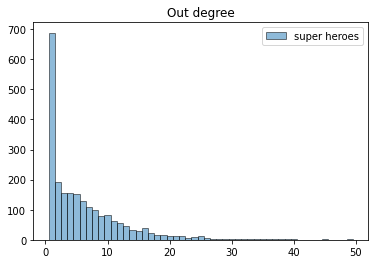

In [14]:
degrees = [G.out_degree(n) for n in G.nodes()]
plt.hist(degrees, edgecolor='black', alpha=0.5,align='right', bins=range(0,50), label='super heroes')
plt.legend(loc='upper right')
plt.title('Out degree')
plt.show()

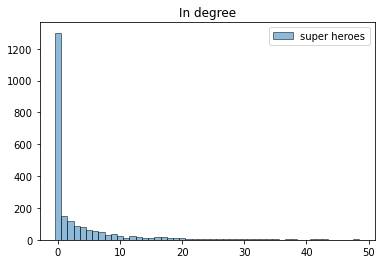

In [21]:
degrees = [G.in_degree(n) for n in G.nodes()]

plt.hist(degrees, edgecolor='black', alpha=0.5,align='left', bins=range(0,50), label='super heroes')
plt.legend(loc='upper right')
plt.title('In degree')
plt.show()

In [22]:
Gsub = max(nx.weakly_connected_components(G))
Gsub = nx.subgraph(G, Gsub)

In [23]:
Gsubud = Gsub.to_undirected()

In [24]:
def sortDegree(e):
  return e['degree']

degree = []

for node in G.nodes:
    degree.append({'name':node,'degree':G.degree(node)})
        
#sort according to in degree
degree.sort(key=sortDegree)

print("Top 3 degree:")
for i in range(-1, -4, -1):
    print("{}: {}".format(degree[i]['name'],degree[i]['degree']))

Top 3 degree:
Spider-Man: 416
Batman: 243
Superman: 243


In [25]:
defined_colors = []
defined_sizes = []

red = "#A83432"
blue = "#323EA8"

gold = "#FFD700"
#silver = "#C0C0C0"
#bronze = "#CD7F32"

black = "#000000"

for node in Gsubud:
    defined_sizes.append(Gsubud.degree(node)**1.8)
    if node == 'Spider-Man' or node == 'Superman' or node == 'Batman':
        defined_colors.append(gold)
    elif Gsubud.nodes[node]['universe'] == 'marvel':
        defined_colors.append(red)
    elif Gsubud.nodes[node]['universe'] == 'dc':
        defined_colors.append(blue)

In [26]:
defined_link_colors = []
defined_link_sizes = []

for link in Gsubud.edges:
    if 'Spider-Man' in link or 'Superman' in link or 'Batman' in link:
        defined_link_colors.append(gold)
        defined_link_sizes.append(10)
    else:
        defined_link_colors.append(black)
        defined_link_sizes.append(1)

In [27]:
forceatlas2 = ForceAtlas2(gravity = 10.0)

In [ ]:
positions = forceatlas2.forceatlas2_networkx_layout(Gsubud, pos=None, iterations=2000)

  5%|████▎                                                                          | 108/2000 [00:05<01:35, 19.73it/s]

In [ ]:
fig = plt.figure(1, figsize=(200, 100), dpi=60)
nx.draw_networkx_nodes(Gsubud, positions, node_size = defined_sizes, alpha=1, node_color = defined_colors)
nx.draw_networkx_edges(Gsubud, positions, width = defined_link_sizes, alpha=0.5, edge_color = defined_link_colors)